# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

Using TensorFlow backend.


In [3]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [4]:
from keras.preprocessing import image

In [5]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
image.load_img

<function keras_preprocessing.image.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

---

## RISE

In [7]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    
    return masks

In [241]:
batch_size = 100

def explain(model, inp, masks, N):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    print(np.argmax(preds, axis=1))
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

In [233]:
def sliding_mask(inp):
    inp = inp[0]
    masked = []
    stepSize = 50
    (w_width, w_height) = (100, 100) # window size
    for x in range(0, inp.shape[1] - int(w_width/4) , stepSize):
        for y in range(0, inp.shape[0] - int(w_height/4), stepSize):
            mask = np.zeros((inp.shape[0], inp.shape[1]))
            mask[x:x + w_width, y:y + w_height] = 1
#             mask = np.resize(mask, inp.shape)
#             plt.figure()
#             plt.imshow(mask)
            masked.append(mask)
    masked = np.array(masked)
    masks = masked.reshape(-1, *model.input_size, 1)
    
    return masks.shape[0], masks

---

## Running explanations

In [10]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [244]:
model = Model()

In [205]:
img, x = load_img('broccoli1.png')

In [197]:
N_rise = 2000
s = 8
p1 = 0.5
masks_rise = generate_masks(2000, 8, 0.5)




Generating masks:   0%|          | 0/2000 [00:00<?, ?it/s]


Generating masks:   1%|          | 20/2000 [00:00<00:10, 195.21it/s]


Generating masks:   2%|▏         | 49/2000 [00:00<00:09, 215.88it/s]


Generating masks:   4%|▍         | 75/2000 [00:00<00:08, 226.90it/s]


Generating masks:   5%|▌         | 100/2000 [00:00<00:08, 231.50it/s]


Generating masks:   6%|▌         | 121/2000 [00:00<00:08, 223.24it/s]


Generating masks:   8%|▊         | 151/2000 [00:00<00:07, 240.52it/s]


Generating masks:   9%|▉         | 182/2000 [00:00<00:07, 256.72it/s]


Generating masks:  11%|█         | 212/2000 [00:00<00:06, 267.37it/s]


Generating masks:  12%|█▏        | 243/2000 [00:00<00:06, 278.10it/s]


Generating masks:  14%|█▎        | 274/2000 [00:01<00:06, 285.85it/s]


Generating masks:  15%|█▌        | 304/2000 [00:01<00:05, 289.15it/s]


Generating masks:  17%|█▋        | 333/2000 [00:01<00:05, 286.17it/s]


Generating masks:  18%|█▊        | 363/2000 [00:01<00:05, 287.86it/s]


Gen

In [242]:
s = 8
p1 = 0.5
N_swage, masks_swage = sliding_mask(x)

In [243]:
sal_swage = explain(model, x, masks_swage, N_swage)




Explaining:   0%|          | 0/1 [00:00<?, ?it/s]


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[937 937 937 950 937 937 937 950 937 937 937 924 677 937 937 937]


In [207]:
sal_rise = explain(model, x, masks_rise, N_rise)




Explaining:   0%|          | 0/20 [00:00<?, ?it/s]


Explaining:   5%|▌         | 1/20 [00:09<03:04,  9.71s/it]


Explaining:  10%|█         | 2/20 [00:19<02:53,  9.64s/it]


Explaining:  15%|█▌        | 3/20 [00:28<02:43,  9.63s/it]


Explaining:  20%|██        | 4/20 [00:38<02:34,  9.64s/it]


Explaining:  25%|██▌       | 5/20 [00:48<02:24,  9.62s/it]


Explaining:  30%|███       | 6/20 [00:57<02:15,  9.65s/it]


Explaining:  35%|███▌      | 7/20 [01:07<02:04,  9.54s/it]


Explaining:  40%|████      | 8/20 [01:16<01:55,  9.59s/it]


Explaining:  45%|████▌     | 9/20 [01:27<01:49,  9.98s/it]


Explaining:  50%|█████     | 10/20 [01:38<01:41, 10.18s/it]


Explaining:  55%|█████▌    | 11/20 [01:48<01:31, 10.21s/it]


Explaining:  60%|██████    | 12/20 [01:58<01:20, 10.01s/it]


Explaining:  65%|██████▌   | 13/20 [02:08<01:11, 10.24s/it]


Explaining:  70%|███████   | 14/20 [02:19<01:01, 10.27s/it]


Explaining:  75%|███████▌  | 15/20 [02:29<00:50, 10.13s/it]


Explaining:  80%|██████

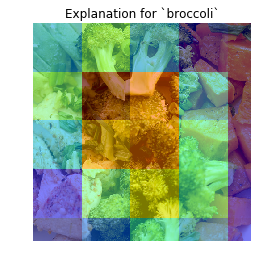

In [236]:

class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

In [237]:
masks_swage.shape

(16, 224, 224, 1)

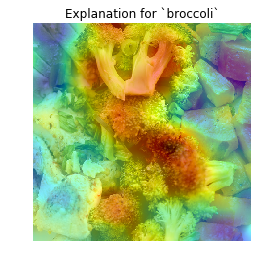

In [214]:
class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

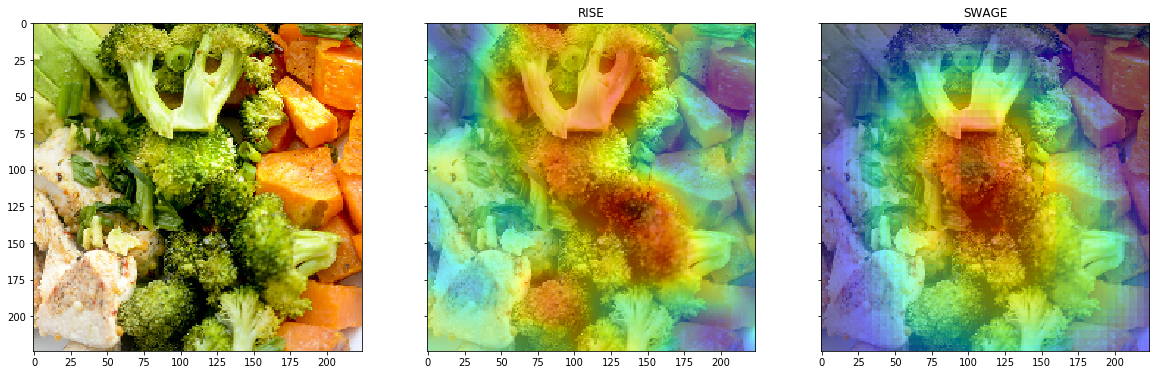

In [208]:
class_idx = 937
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(20,20))

ax1.imshow(img)

ax2.imshow(img)
ax2.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
ax2.set_title('RISE')
# 2nd suplot
ax3.imshow(img)
ax3.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
ax3.set_title('SWAGE')

plt.savefig('explain-broccoli1.png')

In [76]:
masked = true*masks

masked.shape

(2000, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


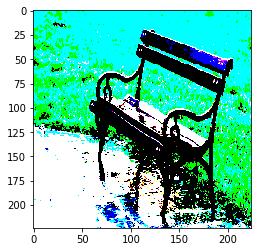

In [49]:
plt.imshow(x.reshape(224,224,3))

TypeError: Invalid dimensions for image data

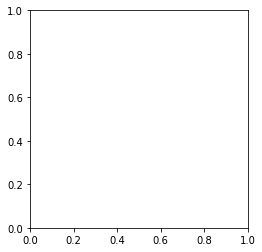

In [51]:

m = masks[9]
m = (m + 1.)/2
plt.imshow(m)
plt.axis('on')
plt.show()